<a href="https://colab.research.google.com/github/rodrigoclira/mindspore-playground/blob/main/mindspore_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting MNIST with MindSpore 

https://github.com/SauravTelge/Mindspore-DL-Framework/blob/main/mindspore_MNIST.ipynb

Instalando MindSpore usando pip

In [1]:
!pip install mindspore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 MB 7.0 MB/s eta 0:00:00


In [2]:
!pip install mindspore-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 MB 4.2 MB/s eta 0:00:00


Checando a instalação e a versão do mindspore

In [3]:
!python -c "import mindspore;print(mindspore.__version__)"

[WARNING] ME(850:140346100414272,MainProcess):2023-03-27-02:55:39.457.321 [mindspore/run_check/_check_version.py:79] MindSpore version 1.10.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.
1.10.0


# Carregando o dataset MNIST

Criando pastas e baixando o MNIST

In [4]:
!apt-get install tree # instalando software auxiliar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 1s (66.9 kB/s)
Selecting previously unselected package tree.
(Reading database ... 128285 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [5]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://github.com/rodrigoclira/mindspore-playground/raw/main/datasets/train-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/train https://github.com/rodrigoclira/mindspore-playground/raw/main/datasets/train-images-idx3-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://github.com/rodrigoclira/mindspore-playground/raw/main/datasets/t10k-labels-idx1-ubyte --no-check-certificate
!wget -NP ./datasets/MNIST_Data/test https://github.com/rodrigoclira/mindspore-playground/raw/main/datasets/t10k-images-idx3-ubyte --no-check-certificate
!tree ./datasets/MNIST_Data

--2023-03-27 02:55:49--  https://github.com/rodrigoclira/mindspore-playground/raw/main/datasets/train-labels-idx1-ubyte
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rodrigoclira/mindspore-playground/main/datasets/train-labels-idx1-ubyte [following]
--2023-03-27 02:55:50--  https://raw.githubusercontent.com/rodrigoclira/mindspore-playground/main/datasets/train-labels-idx1-ubyte
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60008 (59K) [application/octet-stream]
Saving to: ‘./datasets/MNIST_Data/train/train-labels-idx1-ubyte’

train-labels-idx1-u 100%[===================>]  58.60K  --.-KB

# Explorando o dataset

[WARNING] ME(514:140264932239168,MainProcess):2023-03-27-02:55:54.878.12 [mindspore/run_check/_check_version.py:79] MindSpore version 1.10.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


O tipo do mnist dataset: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Número de imagens contidas no dataset： 60000
Um item do mnist_ds: dict_keys(['image', 'label'])
O Tensor de uma imagem  (28, 28, 1)
O label (rótulo) do item: 1


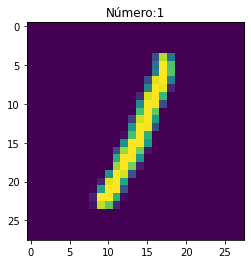

In [6]:
import os
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/MNIST_Data/train"
test_data_path = "./datasets/MNIST_Data/test"
ds.config.set_num_parallel_workers(1)
mnist_ds = ds.MnistDataset(train_data_path)
print('O tipo do mnist dataset:', type(mnist_ds))
print("Número de imagens contidas no dataset：", mnist_ds.get_dataset_size())

dic_ds = mnist_ds.create_dict_iterator()
item = next(dic_ds)
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("Um item do mnist_ds:", item.keys())
print("O Tensor de uma imagem ", img.shape)
print("O label (rótulo) do item:", label)

plt.imshow(np.squeeze(img))
plt.title("Número:%s"% item["label"].asnumpy())
plt.show()


In [7]:
from mindspore.dataset.vision import HWC2CHW, Rescale, Resize
from  mindspore.dataset.transforms import TypeCast
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """
    create dataset for train or test

    Args:
        data_path (str): Data path
        batch_size (int): The number of data records in each group
        repeat_size (int): The number of replicated data records
        num_parallel_workers (int): The number of parallel workers
    """
    # criando o dataset
    mnist_ds = ds.MnistDataset(data_path)

    # criando alguns parâmetros necessário para melhoria dos dados
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # Baseado nos parâmetros, geração dos novos dados melhorados
    resize_op = Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = Rescale(rescale_nml, shift_nml)
    rescale_op = Rescale(rescale, shift)
    hwc2chw_op = HWC2CHW()
    type_cast_op = TypeCast(mstype.int32)

    # Usando a função map map para aplicar as operações no dataset
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # Processando o dataset gerado
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds

ms_dataset = create_dataset(train_data_path)
print('Número de grupos no dataset:', ms_dataset.get_dataset_size())


Número de grupos no dataset: 1875


In [8]:
data = next(ms_dataset.create_dict_iterator(output_numpy=True))
images = data["image"]
labels = data["label"]
print('Tensor de imagens:', images.shape)
print('Labels:', labels)


Tensor de imagens: (32, 1, 32, 32)
Labels: [8 3 7 1 2 7 9 8 8 7 0 0 0 7 7 9 2 2 3 8 7 9 6 1 1 5 1 4 2 7 3 6]


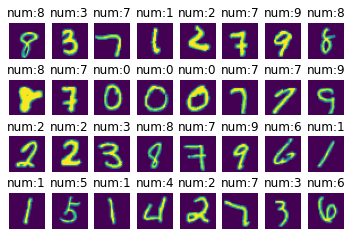

In [9]:
count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()


## Costruindo a LeNet


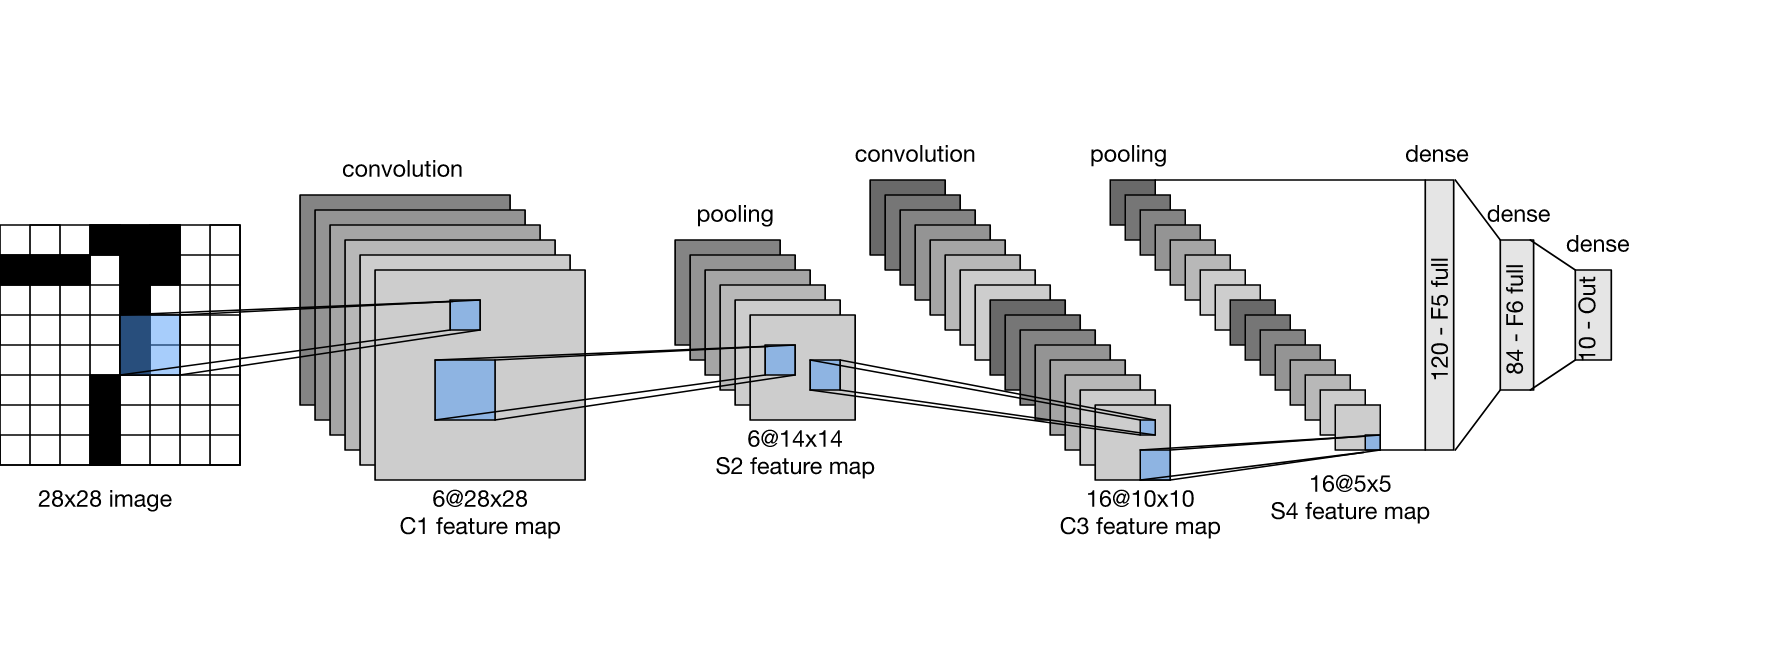

https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

In [10]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.name="LeNet5"
        self.conv1 = nn.Conv2d(in_channels=num_channel, out_channels=6, kernel_size = (5,5), pad_mode='valid')
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = (5,5), pad_mode = 'valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # usando os operadores para construir a rede
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network = LeNet5()
print("Camada conv1:", network.conv1)
print("*"*40)
print("Camada fc1:", network.fc1)


Camada conv1: Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
****************************************
Camada fc1: Dense<input_channels=400, output_channels=120, has_bias=True>


In [11]:
from mindspore.train.callback import Callback

# Callback customizado
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num # 1875
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


In [12]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01
momentum = 0.9

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)
#net_opt = nn.SGD(network.trainable_params(), learning_rate=lr)

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


In [13]:
import os
from mindspore import Tensor, Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy

epoch_size = 2
mnist_path = "./datasets/MNIST_Data"
model_path = "./models/ckpt/mindspore_mnist/"

repeat_size = 1
ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
eval_dataset = create_dataset(os.path.join(mnist_path, "test"), 32)

# Lipando os arquivos antigos 
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))
os.system('rm -rf ./rank_0')

# Criando o modelo
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

# Salvanod o modelo da rede e os parâmetros para realização do fine-tuning
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)

# Indicando a utilização de checkpoints
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}

# coletando os steps,loss e accuracy
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)


[WARNING] ME(514:140264932239168,MainProcess):2023-03-27-02:56:05.246.583 [mindspore/train/model.py:1077] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 125, loss is 2.3062493801116943
epoch: 1 step: 250, loss is 2.288778066635132
epoch: 1 step: 375, loss is 2.290874719619751
epoch: 1 step: 500, loss is 2.280332565307617
epoch: 1 step: 625, loss is 2.27970814704895
epoch: 1 step: 750, loss is 0.47101476788520813
epoch: 1 step: 875, loss is 0.4507524073123932
epoch: 1 step: 1000, loss is 0.16766364872455597
epoch: 1 step: 1125, loss is 0.16039961576461792
epoch: 1 step: 1250, loss is 0.2565958797931671
epoch: 1 step: 1375, loss is 0.17343874275684357
epoch: 1 step: 1500, loss is 0.08728279918432236
epoch: 1 step: 1625, loss is 0.12240086495876312
epoch: 1 step: 1750, loss is 0.1402924656867981
epoch: 1 step: 1875, loss is 0.03779980167746544
epoch: 2 step: 125, loss is 0.27417391538619995
epoch: 2 step: 250, loss is 0.018217669799923897
epoch: 2 step: 375, loss is 0.1523507684469223
epoch: 2 step: 500, loss is 0.009508849121630192
epoch: 2 step: 625, loss is 0.013525618240237236
epoch: 2 step: 750, loss is 0.1757785528898

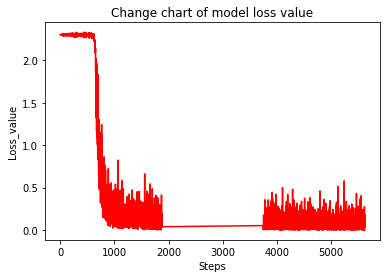

In [14]:
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")
plt.show()


# Prediction

In [16]:
from mindspore import load_checkpoint, load_param_into_net

# testing relate modules
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    param_dict = load_checkpoint("./models/ckpt/mindspore_mnist/checkpoint_lenet-2_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)


============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9844751602564102} ==============


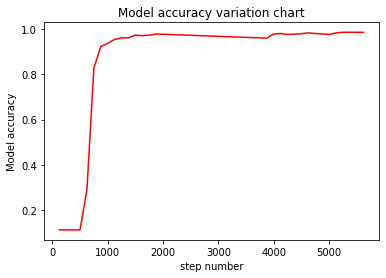

In [17]:
def eval_show(steps_eval):
    plt.xlabel("step number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(steps_eval["step"], steps_eval["acc"], "red")
    plt.show()

eval_show(steps_eval)


Todas as figuras neste grupo são preditas corretamente!
[7 7 6 8 3 5 0 3 2 6 9 6 1 3 3 5 6 1 4 7 7 1 5 5 0 7 9 9 8 8 8 4] <-- Figuras preditas
[7 7 6 8 3 5 0 3 2 6 9 6 1 3 3 5 6 1 4 7 7 1 5 5 0 7 9 9 8 8 8 4] <-- O número correto


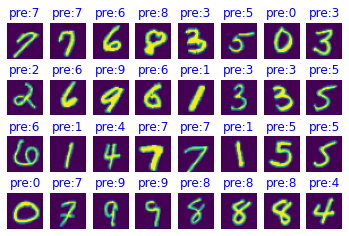

In [18]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()


output = model.predict(Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("Todas as figuras neste grupo são preditas corretamente!")
print(pred, "<-- Figuras preditas")
print(labels, "<-- O número correto")
plt.show()
